In [65]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.utils import dotdict
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

### Load in 3D Vessel Data

In [66]:
data_path='/Users/luke/Downloads/skinVessel/'
data = scio.loadmat(os.path.join(data_path, '899.mat'))
skin = data['skin']
print(skin.shape)

(128, 128, 64)


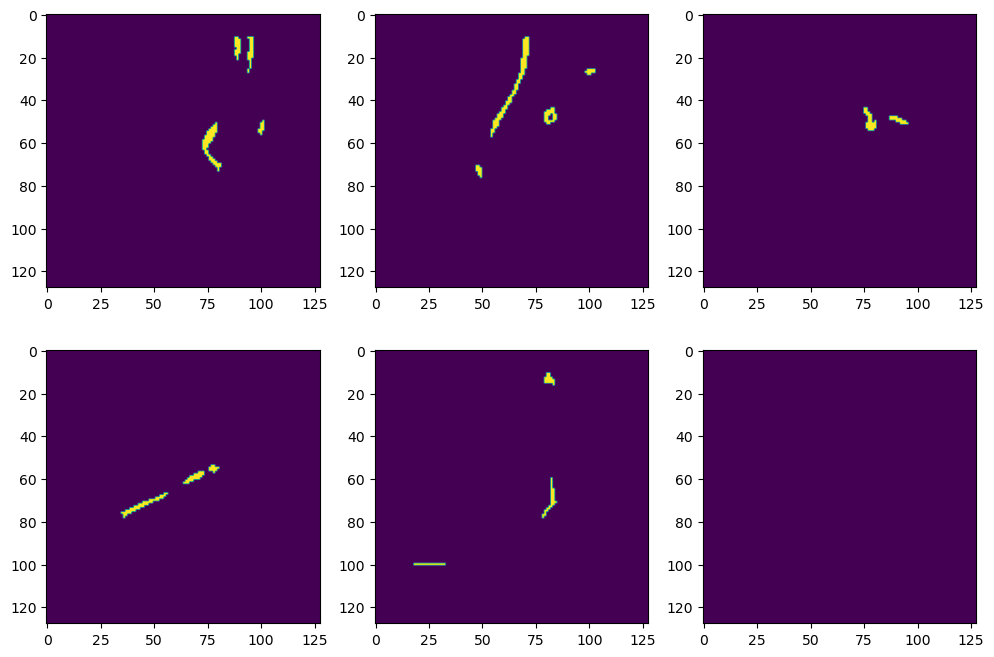

In [67]:
fig = plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(skin[:,:,5*i+11])

### K-wave Forward Simulation

In [68]:
pathname = gettempdir()

# =========================================================================
# SIMULATION
# =========================================================================

# create the computational grid
PML_size = 20               # size of the PML in grid points
Nx = 128 - 2 * PML_size     # number of grid points in the x (row) direction
Ny = 256 - 2 * PML_size     # number of grid points in the y (column) direction
dx = 0.1e-3                 # grid point spacing in the x direction [m]
dy = 0.1e-3                 # grid point spacing in the y direction [m]
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

# define the properties of the propagation medium
medium = kWaveMedium(sound_speed=1500)


source = kSource()
source.p0 = skin[:,:,11]

# smooth the initial pressure distribution and restore the magnitude
source.p0 = smooth(source.p0, True)

# define a binary line sensor
sensor_mask = np.zeros((Nx, Ny))
sensor_mask[0, :] = 1
sensor = kSensor(sensor_mask)

# create the time array
kgrid.makeTime(medium.sound_speed)

# set the input arguements: force the PML to be outside the computational
# grid switch off p0 smoothing within kspaceFirstOrder2D
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False
}

# run the simulation
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})
# assert compare_against_ref(f'out_pr_2D_FFT_line_sensor', input_args['SaveToDisk']), 'Files do not match!'

plt.figure()
plt.imshow(sensor_data)

TypeError: Cannot construct a dtype from an array

### K-wave Time Reversal